In [1]:
import requests
import base64
import datetime
import json
from urllib.parse import urlencode
import pandas as pd
from concurrent.futures import ThreadPoolExecutor as PoolExecutor
import http.client
import socket
import concurrent.futures
import urllib.request
import multiprocessing.pool


In [2]:
client_id = '95c4d81d39da4e55a9f6b8c76eab153c'
client_secret = '6d45241488464b29bf559cf861d537d0'

In [46]:
class SpotifyAPI(object):
    
    access_token = None
    access_token_expires = datetime.datetime.now()
    access_token_did_expire = True
    client_id = None
    client_secret = None
    token_url = "https://accounts.spotify.com/api/token"
    
    def __init__(self,client_id,client_secret,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.client_id = client_id
        self.client_secret = client_secret
        
    def get_client_credentials(self):
        
        client_id = self.client_id
        client_secret = self.client_secret
        if client_id == None or client_secret == None:
            raise Exception("You must set client_id and client_secret")
            
        client_creds =  f"{client_id}:{client_secret}"
        client_creds_b64 = base64.b64encode(client_creds.encode())
        
        return client_creds_b64.decode()
            
        
      
    def get_token_header(self):
        client_creds_b64 = self.get_client_credentials()
        return {
             "Authorization": f"Basic {client_creds_b64}"  
              }
        
    def get_token_data(self):
        return {
             "grant_type" : "client_credentials"
            }
        
    def perform_auth(self):
        token_url = self.token_url
        token_data = self.get_token_data()
        token_headers = self.get_token_header()
        r = requests.post(token_url,data = token_data,headers = token_headers)
        if r.status_code not in range(200,299):
            return False
        data = r.json()
        now = datetime.datetime.now()
        access_token = data['access_token']
        expires_in = data['expires_in']
        expires = now + datetime.timedelta(seconds=expires_in)
        self.access_token = access_token
        self.access_token_expires = expires
        self.access_token_did_expire = expires<now
        return True
    
    def get_access_token(self):
        token = self.access_token
        expires = self.access_token_expires
        now = datetime.datetime.now()
        if expires < now:
            self.perform_auth()
            return self.get_access_token()
        elif token == None:
            self.perform_auth()
            return self.get_access_token() 
        return token
         
    def get_resource_header(self):
        access_token = self.get_access_token()
        headers = {
            "Authorization": f"Bearer {access_token}"
        }
        return headers
        
        
    def get_resource(self, lookup_id, resource_type='albums', version='v1'):
        endpoint = f"https://api.spotify.com/{version}/{resource_type}/{lookup_id}"
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()
    
    def get_playlist(self,user_id):
        headers = self.get_resource_header()
        endpoint = f"https://api.spotify.com/v1/users/{user_id}/playlists"
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in (200,299):
            return {}
        parsed = json.loads(r.text)
        playlist = []
        for i in parsed["items"]:
            playlist.append(f"https://api.spotify.com/v1/playlists/{i['external_urls']['spotify'].split('/')[-1]}/tracks")
        return playlist
                            
    def get_it(self,url):
        headers = self.get_resource_header()
        r = requests.get(url, headers=headers)
        if r.status_code not in (200,299):
            return {}
        data = json.loads(r.text)
        return data   
   
        

    

In [47]:
spotify = SpotifyAPI(client_id,client_secret) 

n = input().split('?')[0].split('/')[-1]


https://open.spotify.com/user/thllebx8zy7sqnbodgkynyhin?si=_-sKy_XaSR2Xd9I9iXeAsA


In [48]:
concurrent = 200
pool = multiprocessing.pool.ThreadPool(processes=concurrent)
return_list = pool.map(spotify.get_it,spotify.get_playlist(n),chunksize=1)
pool.close()

In [100]:
return_list[1]['items'][1]['track']['album']['name']

'Saves The World'

In [113]:
def analyze_playlist(data):
    
    track_id = []
    track_name = []
    first_artist = []
    date_added = []
    parse_date = []
    uri = []
    album_name = []
    for i in range(len(data)):
        for track in data[i]['items']:
            track_id.append(track['track']['id'])
            date_added.append(track['added_at'])
            track_name.append(track['track']['name'])
            first_artist.append(track['track']['artists'][0]['name'])
            uri.append(track['track']['album']['uri'])
            album_name.append(track['track']['album']['name'])
        
    tracks_df = pd.DataFrame([track_id,first_artist,track_name,date_added,uri,album_name])
    tracks_df_new = tracks_df.T # or df1.transpose()
    tracks_df_new.columns = ['id','artist','track_name','added_at','uri','album_name']
    tracks_df_new['added_at'] = pd.to_datetime(tracks_df_new['added_at'] , format = "%Y-%m-%dT%H:%M:%S%fZ")
    return tracks_df_new

In [114]:
tracks = analyze_playlist(return_list)


In [115]:
tracks

,id,artist,track_name,added_at,uri,album_name
0,1Cv1YLb4q0RzL6pybtaMLo,Surfaces,Sunday Best,2020-03-31 23:02:01.600,spotify:album:3mMWlBGocBwsS1Q0o9wvlc,Where the Light Is
1,6zrJLhslleCHby0wbUnvVy,Dua Lipa,Future Nostalgia,2020-03-31 23:02:02.700,spotify:album:7fJJK56U9fHixgO0HQkhtI,Future Nostalgia
2,1SocftHhtuqF7k83eUhHiz,Dominic Fike,Babydoll,2020-03-31 23:02:03.400,spotify:album:1DNx0H5ZX1ax3yyRwtgT4S,"Don't Forget About Me, Demos"
3,7lV3EItl079wZzadtjnQgR,Herizen,Social Jungle,2020-04-03 01:53:00.400,spotify:album:562cXPnBd7myhcmMYTGnyi,Come over to My House
4,20L6erw0ny2hiwQg8c1Dj4,Carlie Hanson,Daze Inn,2020-03-31 23:02:04.900,spotify:album:3BFa8OzNBHwnCWEOKts7r8,Daze Inn
...,...,...,...,...,...,...
1187,4yT3UMHdi1p0xkmLuwOu6f,The Band CAMINO,Haunted,2020-04-30 05:04:00.800,spotify:album:6rbqqMTScIBxRBlM7DayP1,tryhard
1188,5XijWLBY0vwl5MPUpQA2Ha,Halsey,Is There Somewhere,2020-05-02 23:54:04.400,spotify:album:2OIDVh8ubFC6sJs5wpZMP9,Room 93
1189,2qbfKj0DTl7szigi1RSRaL,Ally Hills,Not Now,2020-05-03 16:00:03.400,spotify:album:6X6wQnNvCUEdDqLS1A0K5z,Not Now
1190,5rJ25n6msoaS3kaeZ8kGk7,flor,warm blood,2020-05-07 02:44:02.600,spotify:album:4H1K0LT53ptTEM0e3AJd5C,reimagined


In [136]:
t1 = tracks\
    .assign(year_added=tracks.added_at.dt.year)\
    .groupby(['track_name','year_added']) \
    .count()['id'] \
    .reset_index() \
    .sort_values('id', ascending=False) \
    .rename(columns={'id': 'amount'}) \
    .head()

    
    
    

  

In [141]:
t1

,track_name,year_added,amount
923,everything i wanted,2020,6
861,Where Are You (Acoustic),2020,5
192,Dead Weight,2020,5
868,Who Are You,2020,5
532,No Time To Die,2020,4


In [133]:
t1 = tracks\
    .assign(year_added=tracks.added_at.dt.year)\
    .groupby(['artist','album_name']) \
    .count()['id'] \
    .reset_index() \
    .sort_values('id', ascending=False) \
    .rename(columns={'id': 'amount'}) \
    .head()


In [72]:
tracks\
.assign(year_added=tracks.added_at.dt.year)\
.groupby(['artist','track_name']) \
.count()['id'] \
.reset_index() \
.sort_values('id', ascending=False) \
.rename(columns={'id': 'amount'}) \
.head()
    

,artist,track_name,amount
769,Wallows,Uncomfortable,6
458,PVRIS,Dead Weight,5
676,The Moderates,Where Are You (Acoustic),5
94,Billie Eilish,everything i wanted,5
307,Honest Men,Rose,5


In [200]:
counted_year_df = tracks \
    .assign(year_added=tracks.added_at.dt.year) \
    .groupby(['album_name', 'year_added']) \
    .count()['id'] \
    .reset_index() \
    .rename(columns={'id': 'amount'}) \
    .sort_values('amount', ascending=False)

in_top_5_year_album = counted_year_df \
.groupby('year_added') \
.head(5) \
.album_name \
.unique()

plot = counted_year_df \
[counted_year_df.album_name.isin(in_top_5_year_album)] \
.pivot('album_name', 'year_added') \
.fillna(0) \


In [201]:
plot

amount            
year_added                                   2018  2019  2020
album_name                                                   
All We Know Of Heaven, All We Need Of Hell    0.0  10.0   4.0
BLOODLUST                                     0.0   6.0   0.0
Bummer                                        7.0   0.0   0.0
Fine Line                                     1.0   1.0  10.0
Future Nostalgia                              0.0   0.0  15.0
Hallucinations                                0.0   6.0   3.0
My Mind Makes Noises                          0.0   0.0  16.0
Nothing Happens                               0.0  11.0   4.0
Reaper                                        9.0   0.0   0.0
Spring EP                                     6.0   0.0   0.0
Too Weird To Live, Too Rare To Die!           6.0   0.0   0.0
WHEN WE ALL FALL ASLEEP, WHERE DO WE GO?      0.0   1.0  17.0
White Noise (Deluxe Version)                  1.0  13.0   5.0
dont smile at me                              0.0   0.0  12.0
ruiner                                       11.0   0.0   0.0

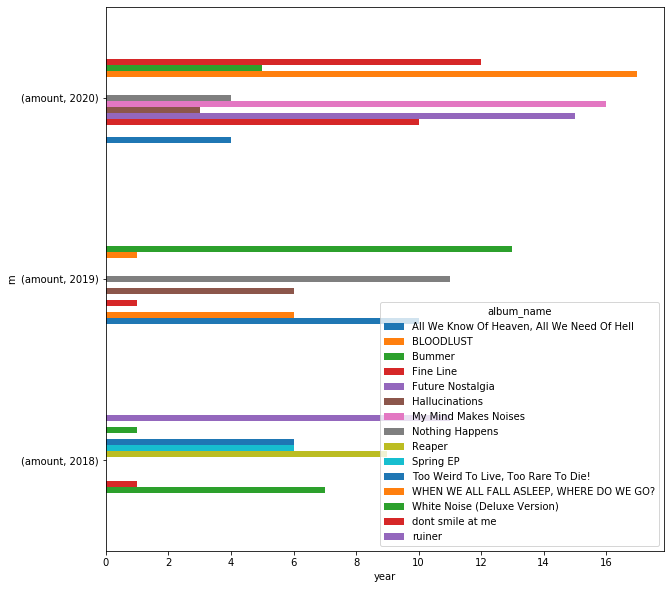

In [202]:
ax = plot.T.plot(kind='barh',figsize=(10, 10))
ylab = ax.set_ylabel('m')
xlab = ax.set_xlabel('year')

In [190]:
counted_year_df = tracks \
    .assign(year_added=tracks.added_at.dt.year) \
    .groupby(['artist', 'year_added']) \
    .count()['id'] \
    .reset_index() \
    .rename(columns={'id': 'amount'}) \
    .sort_values('amount', ascending=False)

in_top_5_year_artist = counted_year_df \
.groupby('year_added') \
.head(5) \
.artist \
.unique()

plot = counted_year_df \
[counted_year_df.artist.isin(in_top_5_year_artist)] \
.pivot('artist', 'year_added') \
.fillna(0) \



In [191]:
plot

amount            
year_added            2018  2019  2020
artist                                
All the Rest           0.0   4.0   0.0
Aries                  2.0   5.0   1.0
Billie Eilish          0.0   2.0  45.0
Fall Out Boy           8.0   0.0   5.0
Halsey                 0.0   0.0  24.0
PVRIS                  2.0  38.0  28.0
Pale Waves             0.0   0.0  17.0
Panic! At The Disco   14.0   0.0   4.0
The Maine              8.0   1.0  20.0
Wallows               13.0  19.0  11.0
nothing,nowhere.      41.0   9.0   5.0

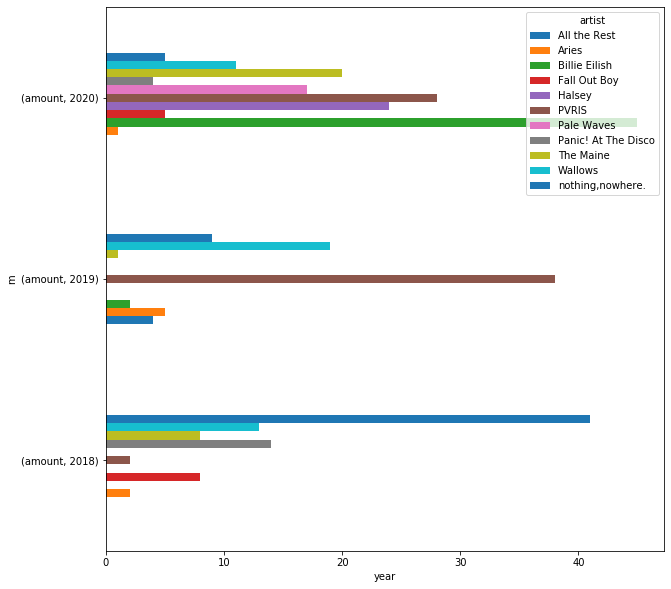

In [193]:
ax = plot.T.plot(kind='barh',figsize=(10, 10))
ylab = ax.set_ylabel('m')
xlab = ax.set_xlabel('year')

In [163]:
pip install pivottablejs

Note: you may need to restart the kernel to use updated packages.


In [198]:
counted_year_df = tracks \
    .assign(year_added=tracks.added_at.dt.year) \
    .groupby(['track_name', 'year_added']) \
    .count()['id'] \
    .reset_index() \
    \
    .sort_values('amount', ascending=False)

in_top_5_year_tracks = counted_year_df \
.groupby('year_added') \
.head(5) \
.track_name \
.unique()

plot = counted_year_df \
[counted_year_df.track_name.isin(in_top_5_year_tracks)] \
.pivot('track_name', 'year_added') \
.fillna(0) \


plot

amount          
year_added                      2018 2019 2020
track_name                                    
Cigarette Daydreams              2.0  0.0  0.0
Coke & Henny Pt. 2               0.0  2.0  1.0
Come and See Me (feat. Drake)    0.0  2.0  0.0
Dead Weight                      0.0  0.0  5.0
Everything To Nothing            2.0  0.0  0.0
Holy                             0.0  2.0  2.0
No Time To Die                   0.0  0.0  4.0
Oceans Away                      2.0  0.0  0.0
Robbers                          2.0  0.0  0.0
Run                              3.0  0.0  0.0
Something I Said                 0.0  2.0  0.0
The Words You Say                0.0  2.0  1.0
Where Are You (Acoustic)         0.0  0.0  5.0
Who Are You                      0.0  0.0  5.0
everything i wanted              0.0  1.0  6.0

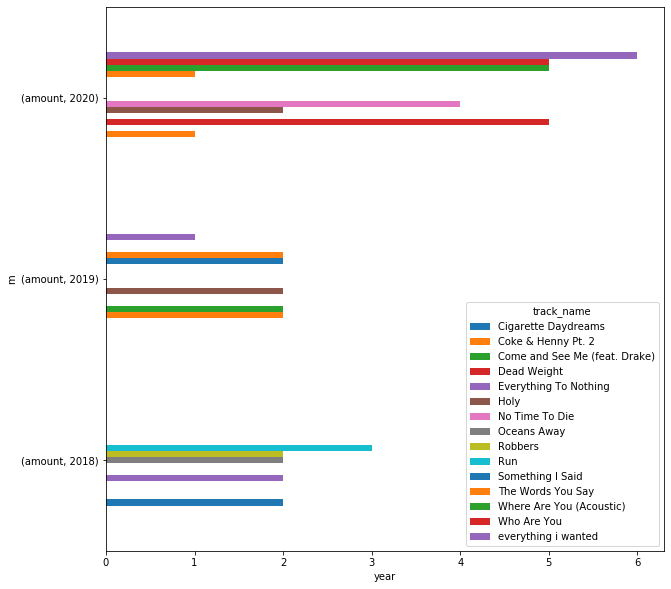

In [199]:
ax = plot.T.plot(kind='barh',figsize=(10, 10))
ylab = ax.set_ylabel('m')
xlab = ax.set_xlabel('year')

In [210]:
import matplotlib.pyplot as plt

t= plot.unstack(level=0)
t

        year_added  album_name                                
amount  2018        All We Know Of Heaven, All We Need Of Hell     0.0
                    BLOODLUST                                      0.0
                    Bummer                                         7.0
                    Fine Line                                      1.0
                    Future Nostalgia                               0.0
                    Hallucinations                                 0.0
                    My Mind Makes Noises                           0.0
                    Nothing Happens                                0.0
                    Reaper                                         9.0
                    Spring EP                                      6.0
                    Too Weird To Live, Too Rare To Die!            6.0
                    WHEN WE ALL FALL ASLEEP, WHERE DO WE GO?       0.0
                    White Noise (Deluxe Version)                   1.0
              